# Presentation

In this notebook we explore 1D optimal transport by computing the barycenter between spectra. 

We'll first explore 1D OT on gaussians followed by 1D OT on pure sine waves. In the end we explore this method on real signals.

We'll compute barycenters using 3 functions:

* Quantile method   
* Entropic barycenter 
* Regularized sinkhorn

In [1]:
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot

from utils import *


## OT between diracs

In this part we compute 1D Optimal transport between diracs


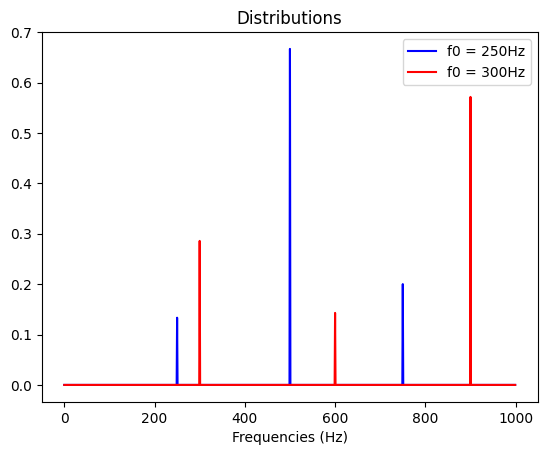

In [34]:
# Define dirac distributions

n = 1000

f1 = n * 0.25
f2 = n * 0.3

a1 = dirac_distribution([f1, f1*2, f1*3], [0.2, 1, 0.3], n=n)
a2 = dirac_distribution([f2, f2*2, f2*3], [1, 0.5, 2], n=n)

frequencies = np.arange(n)

plt.plot(frequencies, a1, color="blue", label=f"f0 = {f1:.0f}Hz")
plt.plot(frequencies, a2, color="red", label=f"f0 = {f2:.0f}Hz")
plt.title('Distributions')
plt.xlabel("Frequencies (Hz)")
plt.legend()

plt.show()

# for other example

# _a1 = dirac_distribution([f1, f1*2], [0.2, 1])
# _a2 = dirac_distribution([f2, f2*2], [1, 0.5])

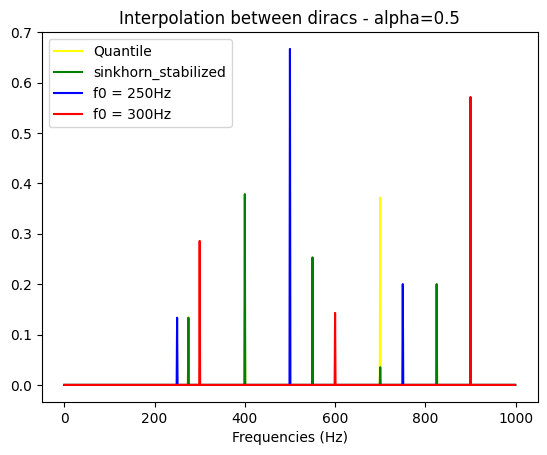

In [36]:
# Optimal transport

alpha = 0.5

# Quantile method 

quantile_interpolation = quantile_optimal_transport(a1, a2, alpha=alpha)

# ot.bregman.sinkhorn_stabilized
M = ot.utils.dist0(n)
M /= M.max()
reg = 1e-2
bary_pot = ot.bregman.sinkhorn_stabilized(a1, a2, M, reg)
barycenter = np.zeros(n)
for i in range(n):
    for j in range(n):
        index = get_frequency(i, j, alpha=alpha, method='int')
        barycenter[index] += bary_pot[i][j]
barycenter /= np.sum(barycenter)

plt.plot(frequencies, quantile_interpolation, label='Quantile', color="yellow")
plt.plot(frequencies, barycenter, label='sinkhorn_stabilized', color="green")
plt.plot(frequencies, a1, label=f"f0 = {f1:.0f}Hz", color="blue")
plt.plot(frequencies, a2, label=f"f0 = {f2:.0f}Hz", color="red")
plt.xlabel("Frequencies (Hz)")
plt.title(f"Interpolation between diracs - alpha={alpha}")
plt.legend()
plt.show()


## OT between gaussians

In this part we compute 1D Optimal transport between two gaussian distributions.


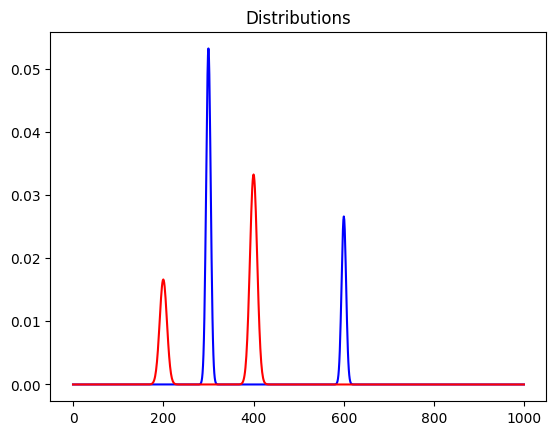

In [18]:
# We compute two 1000-bins gaussian distributions with different mean and std

n = 1000
x = np.arange(n, dtype=np.float64)

f1 = n * 0.3
f2 = n * 0.2
s1 = n * 0.005
s2 = n * 0.008

# Gaussian distributions
a1 = 1.0 * ot.datasets.make_1D_gauss(n, m=f1, s=s1) + 0.5 * ot.datasets.make_1D_gauss(n, m=f1*2, s=s1)
a1 = a1 / np.sum(a1)
a2 = 0.5 * ot.datasets.make_1D_gauss(n, m=f2, s=s2) + 1.0 * ot.datasets.make_1D_gauss(n, m=f2*2, s=s2)
a2 = a2 / np.sum(a2)

fig, ax = plt.subplots()
ax.plot(x, a1, color="blue")
ax.plot(x, a2, color="red")
ax.set_title('Distributions')

plt.show()


In [19]:
# Optimal transport

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

alpha = 0.5  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

# ot.bregman.sinkhorn_stabilized
reg = 1e-2
X_s = a1.reshape(n, 1)
X_t = a2.reshape(n, 1)
bary_pot = ot.bregman.sinkhorn_stabilized(a1, a2, M, reg)


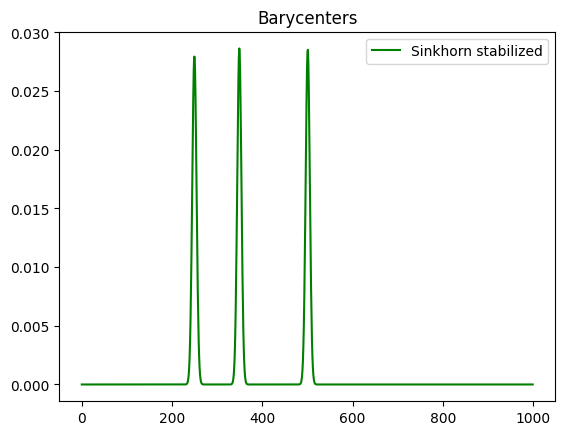

In [20]:
barycenter = np.zeros(n)
for i in range(n):
    for j in range(n):
        index = int((1 - alpha) * i + alpha * j)
        barycenter[index] += bary_pot[i][j]

fig, ax = plt.subplots()

# ax.plot(x, a1, color="blue")
# ax.plot(x, a2, color="red")
ax.plot(x, barycenter, color='g', label='Sinkhorn stabilized')
ax.set_title('Barycenters')

plt.legend()
plt.show()

# On a signal

In [7]:
# Create 440Hz (A4) and 1046.5 (C5) sine waves

sr = 44100
duration = 0.5
frames = np.arange(duration * sr) / sr

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)

A4_freq = 440
A4_signal = np.sin(2 * np.pi * A4_freq * frames)
A4_signal[:smooth_len] *= smoothing
A4_signal[-smooth_len:] *= np.flip(smoothing)

C5_freq = 1046.5
C5_signal = np.sin(2 * np.pi * C5_freq * frames)
C5_signal[:smooth_len] *= smoothing
C5_signal[-smooth_len:] *= np.flip(smoothing)

n_fft = 1024
A4_fft = librosa.stft(A4_signal, n_fft=n_fft)
C5_fft = librosa.stft(C5_signal, n_fft=n_fft)

freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)


In [8]:
# Optimal transport

# dur = 1000

# A4_fft = np.abs(np.fft.fft(A4_signal))
# A4_fft=A4_fft[:dur]
# A4_fft /= np.sum(A4_fft)

# C5_fft = np.abs(np.fft.fft(C5_signal))
# C5_fft=C5_fft[:dur]
# C5_fft /= np.sum(C5_fft)

## 

index = np.random.randint(0, A4_fft.shape[1])

A4_fft = A4_fft[:,index]
A4_fft = np.abs(A4_fft)
A4_fft = A4_fft / np.sum(A4_fft)
C5_fft = C5_fft[:,index]
C5_fft = np.abs(C5_fft)
C5_fft = C5_fft / np.sum(C5_fft)

dur = len(A4_fft)

M = ot.utils.dist0(dur)
M /= M.max()

alpha = 0.5  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

# ot.bregman.sinkhorn_stabilized
reg = 1e-2
bary_pot = ot.bregman.sinkhorn_stabilized(A4_fft, C5_fft, M, reg)


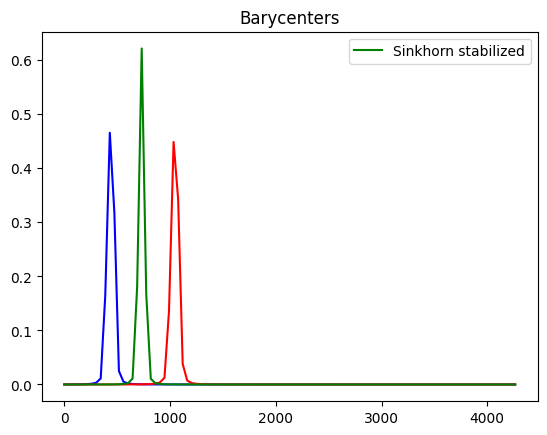

In [9]:
barycenter = np.zeros(dur)
for i in range(dur):
    for j in range(dur):
        index = int((1 - alpha) * i + alpha * j)
        barycenter[index] += bary_pot[i][j]

barycenter /= np.sum(barycenter)

fig, ax = plt.subplots()

length = 100

ax.plot(freqs[:length], A4_fft[:length], color="blue")
ax.plot(freqs[:length], C5_fft[:length], color="red")
ax.plot(freqs[:length], barycenter[:length], color='g', label='Sinkhorn stabilized')
ax.set_title('Barycenters')

plt.legend()
plt.show()

# On a real signal

In [10]:
duration = 0.3 # in seconds

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)


A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)

n_fft = 1024
A_fft = librosa.stft(A_signal, n_fft=n_fft)
C_fft = librosa.stft(C_signal, n_fft=n_fft)

freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)


In [11]:
# Optimal transport
sinkhorn_stabilized_interpolation = []

for index in range(A_fft.shape[1]):
    if index % 10 == 0:
        print(f"At frame {index}")

    A_frame = A_fft[:,index]
    A_frame = np.abs(A_frame)
    A_frame = A_frame / np.sum(A_frame)
    C_frame = C_fft[:,index]
    C_frame = np.abs(C_frame)
    C_frame = C_frame / np.sum(C_frame)

    dur = len(A_frame)

    M = ot.utils.dist0(dur)
    M /= M.max()

    alpha = 0.5  # 0<=alpha<=1
    weights = np.array([1 - alpha, alpha])

    # ot.bregman.sinkhorn_stabilized
    reg = 1e-4
    bary_pot = ot.bregman.sinkhorn_stabilized(A_frame, C_frame, M, reg)
    sinkhorn_stabilized_interpolation.append(bary_pot)

    # ot.bregman.barycenter_stabilized
    # reg = 1e-5
    # A = np.vstack((A_frame, C_frame)).T
    # bary_pot_stab = ot.bregman.barycenter_stabilized(A, M, reg, weights=weights)
    # sinkhorn_stabilized_interpolation.append(bary_pot_stab)

sinkhorn_stabilized_interpolation = np.array(sinkhorn_stabilized_interpolation)

At frame 0


e:\Dauphine\Cours\Mémoire\audio_1D_transport\.venv\lib\site-packages\ot\bregman.py:1150: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


At frame 10


KeyboardInterrupt: 

Text(0.5, 1.0, 'Interpolated spectrogram')

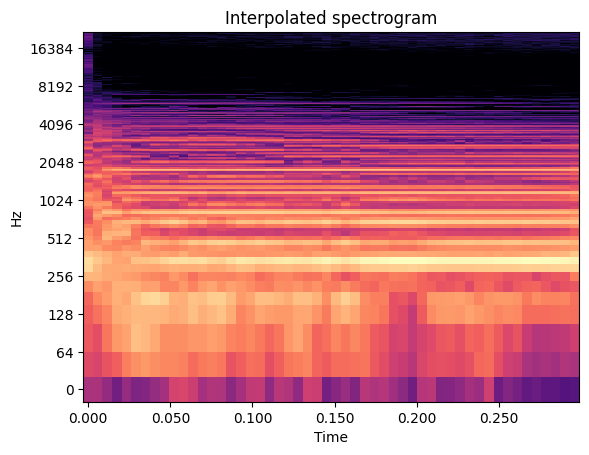

In [ ]:
res = []

for frame in sinkhorn_stabilized_interpolation:
    barycenter = np.zeros(dur)
    for i in range(dur):
        for j in range(dur):
            index = int((1 - alpha) * i + alpha * j)
            barycenter[index] += frame[i][j]

    barycenter /= np.sum(barycenter)

    res.append(barycenter)

res = np.array(res).T

# res = np.array(sinkhorn_stabilized_interpolation).T
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(res, ref=np.max), y_axis='log', x_axis='time', ax=ax, sr=sr, n_fft=n_fft, hop_length=n_fft//4)
ax.set_title('Interpolated spectrogram')

In [ ]:
inversed = librosa.griffinlim(res, n_iter=200)
audio_widgets = []

title = widgets.Label(f'A4')
audio_player = IPython.display.Audio(data=A_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'C5')
audio_player = IPython.display.Audio(data=C_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Sinkhorn interpolation')
audio_player = IPython.display.Audio(data=inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid